In [31]:
import torch
import torch.nn as nn
import torch.optim as opt
from model.sffnet import USFFNet
from utils.evaluate import Evaluate

from torch.utils.data import DataLoader, TensorDataset
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./logs')
from torchvision import utils as vutils
import os
import random
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [32]:
device = 'cuda:0'
batch_size = 128
stride = 1
window_size = 150

path = './datasets/SOC/0degC'
train_list = ['589_Mixed1.csv', '589_Mixed2.csv', '590_Mixed4.csv', '590_Mixed5.csv', '590_Mixed6.csv', '590_Mixed7.csv']
test_list = ['590_Mixed8.csv']

In [33]:
from utils.build_dataloader import get_dataloder
train_loader, test_loader = get_dataloder(path, window_size, stride, train_list, test_list, batch_size, device)

loading data...


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


In [34]:
test_ratio = 1
epoches = 20
weight_decay = 1e-4
learning_rate = 5e-4
loss_funcation = nn.MSELoss()
evaluater = Evaluate(path.split('/')[1], 'Ablation', test_ratio)
block_num = 5
feature_num = 3

spa_ks_list = [3, 5, 7, 7, 7]
fre_ks_list = [3, 5, 7, 7, 7]
fus_ks_list = [3, 3, 7, 7, 7]
mid_channel_list = [32, 16, 8, 4, 4]


In [35]:
import torch
import math
import torch.nn.init as init
import torch.nn as nn
import torch.fft as fft
from model.uncertainty_head import UncertaintyHead
from model.basic_module import *
from Embed import *
from torchvision import utils as vutils
import time


class SpatialFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(SpatialFlow, self).__init__()
        padding = int(kernel_size//2)
        self.up_conv1 = nn.Conv1d(feature_num  ,feature_num*2,kernel_size,1,padding)
        self.up_conv2 = nn.Conv1d(feature_num*2,feature_num*4,kernel_size,1,padding)

        self.c_conv = nn.Conv1d(feature_num*4, feature_num*4,kernel_size,1,padding)

        self.down_conv2 = nn.Conv1d(feature_num*4,feature_num*2,kernel_size,1,padding)
        self.down_conv1 = nn.Conv1d(feature_num*2,feature_num  ,kernel_size,1,padding)
        # self.icb = ICB(feature_num,mid_channel)
        # up_sampling

        # down_sampling

        self.Spa_CNN = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding),
                                      nn.ReLU(),
                                      nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding),
                                      )
        self.act = nn.ReLU()


    def forward(self, x):
        Spa_feature = self.Spa_CNN(x)

        return Spa_feature


class FrequencyFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(FrequencyFlow, self).__init__()
        padding = int(kernel_size//2)
        self.pha_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))
        self.amp_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))

    def make_complex(self, phase, amplitude):
        real = amplitude * torch.cos(phase)
        im = amplitude * torch.sin(phase)
        complex_num = torch.complex(real, im)
        return complex_num

    def forward(self, x):
        frequency = fft.fft(x, dim=2, norm='backward')
        phase = torch.angle(frequency)
        magnitude = torch.abs(frequency)
        refine_phase = self.pha_process(phase)
        refine_magnitude = self.amp_process(magnitude)
        refine_spatial = self.make_complex(refine_phase, refine_magnitude)
        Fre_feature = torch.abs(fft.ifft(refine_spatial, dim=2, norm='backward'))
        return Fre_feature


class FusionBlock(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(FusionBlock, self).__init__()
        self.SA = SpatialAttention(kernel_size)
        self.CA = ChannelAttention(feature_num, r)


    def forward(self, fre_feature, spa_feature):
        spatial_refine_feature = self.SA(fre_feature - spa_feature)
        channel_refine_feature = self.CA(fre_feature + spa_feature)
        return channel_refine_feature + spatial_refine_feature

class ICB(nn.Module):
    def __init__(self, in_features, hidden_features, drop=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(in_features, hidden_features, 1)
        self.conv2 = nn.Conv1d(in_features, hidden_features, 3, 1, padding=1)
        self.conv3 = nn.Conv1d(hidden_features, hidden_features, 1)
        self.drop = nn.Dropout(drop)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_features)

    def forward(self, x):
        # x = x.transpose(1, 2)
        x1 = self.conv1(x)
        x1_1 = self.act(x1)
        x1_2 = self.drop(x1_1)

        x2 = self.conv2(x)
        x2_1 = self.act(x2)
        x2_2 = self.drop(x2_1)

        out1 = x1 * x2_2
        out2 = x2 * x1_2

        out = self.conv3(out1 + out2)

        return out




class CRU(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(CRU, self).__init__()
        self.vc_channel = 2
        self.t_channel = 1
        ratio = 2
        self.vc_conv1   = nn.Conv1d(self.vc_channel,self.vc_channel*ratio,kernel_size)
        self.t_conv1 = nn.Conv1d(self.t_channel,self.t_channel*ratio,kernel_size)

        self.vc_conv2 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,1)
        self.t_conv2 = nn.Conv1d(self.t_channel*ratio,self.t_channel,1)

        self.vc_conv3 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,kernel_size)
        self.t_conv3 = nn.Conv1d(self.t_channel*ratio,self.t_channel,kernel_size)

    def forward(self, x):
        vc,t = torch.split(x,[self.vc_channel,self.t_channel],dim=1)
        vc = self.vc_conv(vc)
        t  = self.t_conv(t)

        vc = self.vc_conv2(vc) + self.vc_conv3(vc)
        t = self.t_conv2(t) + self.vc_conv3(t)

        feature = torch.cat([vc,t],dim=1)

        return feature + x

class PAIFILTER(nn.Module):

    def __init__(self,hidden_size,seq_len):
        super(PAIFILTER, self).__init__()
        self.seq_len = seq_len
        self.pred_len = 1
        self.scale = 0.02

        self.embed_size = self.seq_len
        self.hidden_size = hidden_size

        self.w = nn.Parameter(self.scale * torch.randn(3, self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pred_len)
        )
        self.softmx = nn.Softmax(dim=1)


    def circular_convolution(self, x, w):
        x = torch.fft.rfft(x, dim=2, norm='ortho')
        w = torch.fft.rfft(w, dim=1, norm='ortho')
        y = x * w
        out = torch.fft.irfft(y, n=self.embed_size, dim=2, norm="ortho")
        return out

    def forward(self, x):
        x = self.circular_convolution(x, self.w.to(x.device))  # B, N, D
        x = self.fc(x)
        x = self.softmx(x)

        return x


class SFFBlock(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, spa_ks, fre_ks, fus_ks, r, fb, sf, ff):
        super(SFFBlock, self).__init__()
        self.fb, self.sf, self.ff = fb, sf, ff
        if fb is True:
            self.FB = FusionBlock(window_size, fus_ks, feature_num, r)
        if sf is True:
            self.SF = SpatialFlow(window_size, feature_num, mid_channel, spa_ks)
        if ff is True:
            self.FF = FrequencyFlow(window_size, feature_num, mid_channel, fre_ks)

        self.ffn = nn.Linear(feature_num*2,feature_num)
        self.act = nn.Sigmoid()
        self.icb = ICB(feature_num*2,feature_num)

    def forward(self, x):

        if self.sf is True:
            Spa_feature = self.SF(x)
        if self.ff is True:
            Fre_feature = self.FF(x)
        if self.fb is True:
            # feature = Spa_feature
            # feature = Fre_feature
            # feature = Fre_feature + Spa_feature
            # feature = self.ffn(torch.concat([Spa_feature , Fre_feature],dim=1).transpose(2,1)).transpose(1,2)
            # feature = self.FB(Spa_feature,Fre_feature)
            feature = self.icb(torch.concat([Spa_feature , Fre_feature],dim=1))

        return feature+x


class USFFNet(nn.Module):

    def __init__(self, num_block, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list):
        super(USFFNet, self).__init__()
        self.SFFBlock = nn.Sequential()
        for i in range(num_block):
             self.SFFBlock.add_module('SFFBlock'+str(i), SFFBlock(window_size, feature_num, mid_channel_list[i], spa_ks_list[i], fre_ks_list[i], fus_ks_list[i], 2, True, True, True))
        self.CNNI = nn.Sequential(nn.Conv1d(feature_num, 1, 3, 1, 1))
        self.Uncertainty_Head = UncertaintyHead(window_size,stride)
        # self.icb = ICB(feature_num, feature_num)
        self.embedding = DataEmbedding(feature_num,feature_num)

        self.paifilter = PAIFILTER(hidden_size=50,seq_len=window_size)

    def forward(self, x):

        embeded_x = self.embedding(x)
        # print(feature.shape)
        # feature, weight  = self.Adaptive_Spectral_Block(embeded_x)
        # print(feature.shape,sum(freq_mask))
        # print(feature.shape)

        weight = self.paifilter(embeded_x)

        # feature = self.SFFBlock(feature + x )
        feature = self.SFFBlock(weight * embeded_x + x)
        # feature = self.CNNI(feature)
        # feature = self.icb(feature)
        #

        feature = feature.reshape(feature.shape[0], feature.shape[1]*feature.shape[2])

        gamma, nu, alpha, beta = self.Uncertainty_Head.forward(feature)
        return gamma, nu, alpha, beta




In [36]:
model = USFFNet(block_num, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list).to(device)

optimizer = opt.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
evaluater.record_param_setting(window_size, stride, batch_size, learning_rate, weight_decay, model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)


In [37]:
lambda_coef = []
train_loss = []
vaild_loss = []

In [38]:
for epoch in range(epoches):
    model.train()
    epoch_loss = 0
    print('epoch: '+str(epoch))
    for x, y in tqdm(train_loader):
        # train
        gamma, nu, alpha, beta = model.forward(x)
        loss, nig_loss, nig_regularization = model.Uncertainty_Head.get_loss(y, gamma, nu, alpha, beta)

        loss = loss_funcation(gamma, y)+loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.Uncertainty_Head.hyperparams_update(nig_regularization)
        # print(gamma.shape)
        _loss = loss_funcation(gamma, y)
        epoch_loss += _loss.item()

    epoch_loss /= train_loader.__len__()
#     writer.add_scalar("Loss/train",epoch_loss,epoch)
    lambda_coef.append(model.Uncertainty_Head.lambda_coef.detach().cpu().numpy())
    train_loss.append(epoch_loss)
    print('trainning_loss = '+str(epoch_loss))
    if epoch%test_ratio == 0:
        model.eval()
        epoch_loss = 0
        for x, y in test_loader:
            gamma, nu, alpha, beta = model.forward(x)
            gamma = torch.cat((gamma[:5], (gamma[:-5] + gamma[1:-4]  + gamma[2:-3] + gamma[3:-2] + gamma[4:-1]) / 5), dim=0)
            _loss = loss_funcation(gamma, y)
            epoch_loss += _loss.item()
        epoch_loss /= test_loader.__len__()
#         writer.add_scalar('Loss/vali',epoch_loss,epoch)

        vaild_loss.append(epoch_loss)
        print('testing_loss = '+str(epoch_loss))

    # if early_stopping.early_stop:
    #     print("Early stopping")
    #    break
    evaluater.visualize(train_loss, vaild_loss, model, None)

epoch: 0


100%|██████████| 2810/2810 [01:31<00:00, 30.69it/s]


trainning_loss = 0.0022788900583510176
testing_loss = 0.001363947719423543
Validation loss decreased (1.000000 --> 0.001364).  Saving model ...
epoch: 1


100%|██████████| 2810/2810 [01:35<00:00, 29.55it/s]


trainning_loss = 0.0013002532775417712
testing_loss = 0.0014116926884781833
epoch: 2


100%|██████████| 2810/2810 [01:32<00:00, 30.26it/s]


trainning_loss = 0.0011804674417310761
testing_loss = 0.001540985217565261
epoch: 3


100%|██████████| 2810/2810 [01:32<00:00, 30.30it/s]


trainning_loss = 0.0010770454273013948
testing_loss = 0.0020448123732287916
epoch: 4


100%|██████████| 2810/2810 [01:34<00:00, 29.80it/s]


trainning_loss = 0.0010119880320093332
testing_loss = 0.001747166847853437
epoch: 5


100%|██████████| 2810/2810 [01:31<00:00, 30.77it/s]


trainning_loss = 0.0009666502316651395
testing_loss = 0.0019414248705816937
epoch: 6


100%|██████████| 2810/2810 [01:31<00:00, 30.69it/s]


trainning_loss = 0.0009257862030767116
testing_loss = 0.001703017348812436
epoch: 7


100%|██████████| 2810/2810 [01:30<00:00, 30.95it/s]


trainning_loss = 0.0008949683815198602
testing_loss = 0.001180736746797894
Validation loss decreased (0.001364 --> 0.001181).  Saving model ...
epoch: 8


100%|██████████| 2810/2810 [01:32<00:00, 30.48it/s]


trainning_loss = 0.0008628500368113852
testing_loss = 0.0019222935094627006
epoch: 9


100%|██████████| 2810/2810 [01:34<00:00, 29.86it/s]


trainning_loss = 0.0008411472668979828
testing_loss = 0.001085148457279087
Validation loss decreased (0.001181 --> 0.001085).  Saving model ...
epoch: 10


100%|██████████| 2810/2810 [01:31<00:00, 30.76it/s]


trainning_loss = 0.0008162794525845282
testing_loss = 0.0010633337956612783
Validation loss decreased (0.001085 --> 0.001063).  Saving model ...
epoch: 11


100%|██████████| 2810/2810 [01:32<00:00, 30.38it/s]


trainning_loss = 0.0007954142493066574
testing_loss = 0.0008083341833210009
Validation loss decreased (0.001063 --> 0.000808).  Saving model ...
epoch: 12


100%|██████████| 2810/2810 [01:33<00:00, 30.07it/s]


trainning_loss = 0.0007839832605617585
testing_loss = 0.0011596372282353434
epoch: 13


100%|██████████| 2810/2810 [01:11<00:00, 39.35it/s]


trainning_loss = 0.0007698750771019522
testing_loss = 0.0010191124620077703
epoch: 14


100%|██████████| 2810/2810 [01:08<00:00, 41.01it/s]


trainning_loss = 0.0007494608365273554
testing_loss = 0.0006334915764177688
Validation loss decreased (0.000808 --> 0.000633).  Saving model ...
epoch: 15


100%|██████████| 2810/2810 [01:09<00:00, 40.45it/s]


trainning_loss = 0.0007332108263382059
testing_loss = 0.0007094475243852284
epoch: 16


100%|██████████| 2810/2810 [01:05<00:00, 43.04it/s]


trainning_loss = 0.0007190606919853878
testing_loss = 0.0007918639683335935
epoch: 17


100%|██████████| 2810/2810 [01:06<00:00, 42.56it/s]


trainning_loss = 0.0007057288643784714
testing_loss = 0.0006616540582988381
epoch: 18


100%|██████████| 2810/2810 [01:06<00:00, 42.11it/s]


trainning_loss = 0.0006866037146394635
testing_loss = 0.0007604103336471807
epoch: 19


100%|██████████| 2810/2810 [00:58<00:00, 47.88it/s]


trainning_loss = 0.0006654446643302416
testing_loss = 0.0006835130476763057


<Figure size 640x480 with 0 Axes>

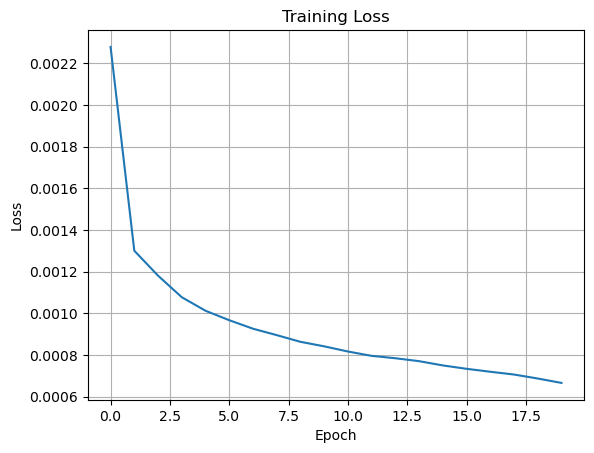

In [39]:
# train_loss plot
import matplotlib.pyplot as plt
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.plot(range(len(train_loss)), train_loss)
plt.show()